# Conectar à Base de Dados e Carregar Dados

In [93]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# --- Database Connection ---
db_user = 'candidate_c'
db_password = 'Rz6#760810da'
db_host = '35.246.201.88'
db_port = '5432'            # default PostgreSQL port
db_name = 'candidate_db'

# Create the database connection engine
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

# --- Load Data ---
# Replace 'appointments_table' with the actual table name from the DB
query = "SELECT * FROM appointments;"   
df = pd.read_sql(query, engine)

# Inspeção Inicial

## Valores nulos

In [94]:
# --- Initial Inspection ---
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219800 entries, 0 to 219799
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   appointment_id                    219800 non-null  int64              
 1   tenant                            219800 non-null  object             
 2   created_at                        219800 non-null  datetime64[ns, UTC]
 3   updated_at                        219800 non-null  datetime64[ns, UTC]
 4   start_time                        219800 non-null  datetime64[ns, UTC]
 5   end_time                          219800 non-null  datetime64[ns, UTC]
 6   started_at                        219005 non-null  datetime64[ns, UTC]
 7   finished_at                       203937 non-null  datetime64[ns, UTC]
 8   realization_sla                   219534 non-null  float64            
 9   duration_minutes                  203174 non-nul

C:\Users\Mariana Saavedra\AppData\Local\Temp\ipykernel_16028\2544716546.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.values, y=missing_pct.index, palette='coolwarm')


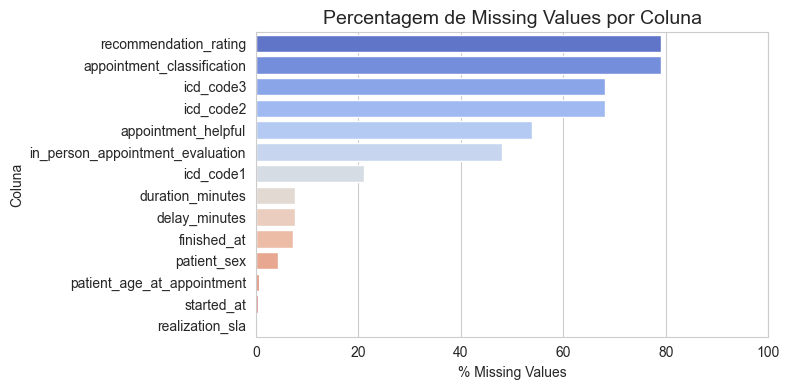

Missing Values (%) por Coluna:
recommendation_rating               79.10
appointment_classification          79.10
icd_code3                           68.15
icd_code2                           68.15
appointment_helpful                 53.86
in_person_appointment_evaluation    48.02
icd_code1                           21.13
duration_minutes                     7.56
delay_minutes                        7.56
finished_at                          7.22
patient_sex                          4.40
patient_age_at_appointment           0.67
started_at                           0.36
realization_sla                      0.12
dtype: float64


In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missing values percentage
missing_pct = df.isna().mean() * 100
missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,4))
sns.barplot(x=missing_pct.values, y=missing_pct.index, palette='coolwarm')
plt.title('Percentagem de Missing Values por Coluna', fontsize=14)
plt.xlabel('% Missing Values')
plt.ylabel('Coluna')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()

# Optional: print table
print("Missing Values (%) por Coluna:")
print(missing_pct.round(2))


Observações sobre valores em falta:
Algumas variáveis apresentam um elevado número de missing values e não serão analisadas.

- recommendation_rating (~79% missing)
- appointment_classification (~79% missing)
- icd_code2 / icd_code3 (~68% missing)
- appointment_helpful (~54% missing)

Estas variáveis não serão consideradas na análise principal devido ao risco de viés e à reduzida cobertura de dados

Começamos por identificar as variáveis contínuas de interesse:

Principais variáveis contínuas de interesse para detecção de outliers

- realization_sla → tempo desde a marcação até ao início
- duration_minutes → duração da consulta
- delay_minutes → tempo de atraso

Secundárias

- recommendation_rating → maioritariamente de 0 a 10, pode verificar-se a existência de anomalias, mas geralmente menos extremas
- patient_age_at_appointment → apenas alguns erros de digitação, normalmente seguro ignorar para boxplots de outliers.


## Estatisticas descritivas

In [96]:
# Count appointments per tenant
tenant_counts = df["tenant"].value_counts()

# Calculate percentages
tenant_percentages = df["tenant"].value_counts(normalize=True) * 100

# Combine into a single DataFrame
tenant_summary = pd.DataFrame({
    "appointments": tenant_counts,
    "percentage": tenant_percentages.round(2)
})

print(tenant_summary)

        appointments  percentage
tenant                          
knok          219800       100.0


In [97]:
# Count appointments per status
status_counts = df["status"].value_counts()

# Calculate percentages
status_percentages = df["status"].value_counts(normalize=True) * 100

# Combine into a DataFrame
status_summary = pd.DataFrame({
    "appointments": status_counts,
    "percentage": status_percentages.round(2)
})

print(status_summary)


          appointments  percentage
status                            
finished        203476       92.57
no-show          16324        7.43


In [98]:
print(df.describe(include='all').T.head(20))  # better overview, including categorical

                               count unique       top    freq  \
appointment_id              219800.0    NaN       NaN     NaN   
tenant                        219800      1      knok  219800   
created_at                    219800    NaN       NaN     NaN   
updated_at                    219800    NaN       NaN     NaN   
start_time                    219800    NaN       NaN     NaN   
end_time                      219800    NaN       NaN     NaN   
started_at                    219005    NaN       NaN     NaN   
finished_at                   203937    NaN       NaN     NaN   
realization_sla             219534.0    NaN       NaN     NaN   
duration_minutes            203174.0    NaN       NaN     NaN   
delay_minutes               203174.0    NaN       NaN     NaN   
status                        219800      2  finished  203476   
service_type                  219800      2    remote  124241   
appointment_helpful           101419      2     False   59419   
appointment_classificatio

In [99]:
# Lista de variáveis contínuas de interesse
continuous_vars = ['realization_sla', 'duration_minutes', 'delay_minutes']

# Seleciona apenas essas colunas
df_cont = df[continuous_vars]

# Calcula min, max e mean
summary_table = df_cont.agg(['min', 'max', 'mean']).T  # transposta para formato amigável
summary_table = summary_table.round(2)  # arredonda para 2 casas decimais

# Exibe
summary_table


,min,max,mean
realization_sla,-60.88,100522.77,222.40
duration_minutes,0.02,51368.58,10.67
delay_minutes,-5560.65,5967.67,4.95


Quando comparamos os máximos e minimos com o valor médio das estatisticas descritiva, 3 variáveis continuas destacam-se pelos seus valores extremos:

realization_sla: Em média, passam-se 3.7 horas desde o momento de agendamento até ao iniciar da consulta. Conduto, vemos que o valor máximo atinge cerca de 70 dias de espera e que o valor mínimo é negativo, que é realisticamente impossível

duration_minutes: O mesmo acontece com esta varíavel, qwue apresenta durações de consulta máxima de 35 dias e mínima de 1 segundo.

delay_minutes: Também nos atrasos vemos valores extremos como o mínimo negativo que não é possível.

Vamos então olhar para a distribuição destas variàveis para confirmar ou rejeitar estas suspeitas.

# Identificar e Visualizar Outliers

In [100]:
# Count negative values
neg_count = (df['delay_minutes'] < 0).sum()
total_count = df['delay_minutes'].notna().sum()  # only consider non-missing

# Percentage
neg_pct = 100 * neg_count / total_count

print(f"Negative values in delay_minutes: {neg_count} ({neg_pct:.2f}%)")


Negative values in delay_minutes: 69377 (34.15%)


In [101]:
# Count negative values
neg_count = (df['realization_sla'] < 0).sum()
total_count = df['realization_sla'].notna().sum()  # only consider non-missing

# Percentage
neg_pct = 100 * neg_count / total_count

print(f"Negative values in realization_sla: {neg_count} ({neg_pct:.2f}%)")


Negative values in realization_sla: 930 (0.42%)


In [102]:

df = df[df['realization_sla'] >= 0]
df = df[df['duration_minutes'] >= 0]

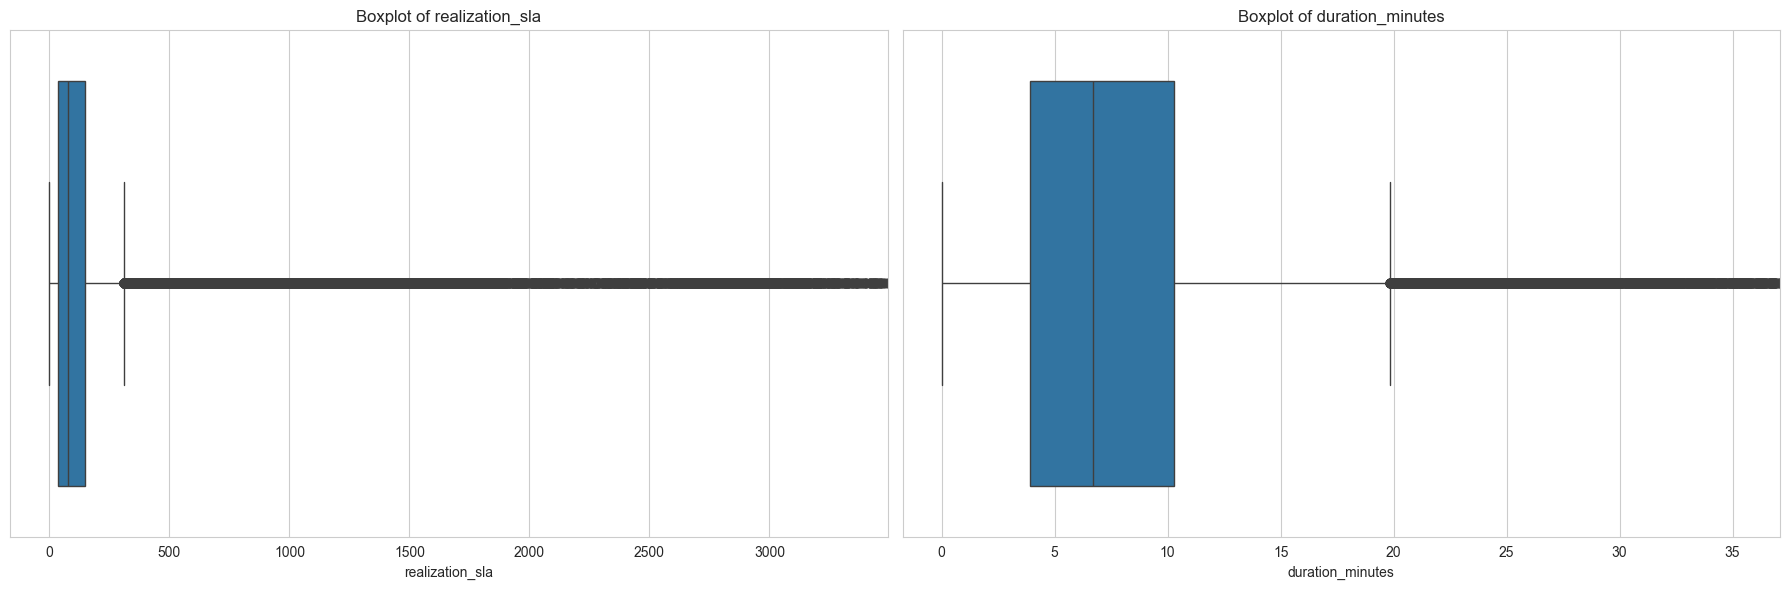

In [103]:
# --- Boxplots with buffer on x-axis ---
fig, axes = plt.subplots(1,2, figsize=(18, 6))

continuous_vars = ["realization_sla", "duration_minutes"]
buffer = 0.05  # 5% of range as buffer

for i, col in enumerate(continuous_vars):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    
    # Zoom to 1%-99% percentile
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    
    # Add buffer
    x_range = upper - lower
    axes[i].set_xlim(lower - buffer * x_range, upper + buffer * x_range)

plt.tight_layout()
plt.show()


In [104]:
def tukey_bounds_positive(series):
    """
    Calcula os limites de Tukey (IQR) garantindo que o limite inferior não seja negativo.
    Retorna (lower, upper) bounds.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(0, Q1 - 1.5 * IQR)  # limite inferior nunca negativo
    upper = Q3 + 1.5 * IQR
    return lower, upper


In [105]:


# Lista das variáveis contínuas
continuous_vars = ["realization_sla", "duration_minutes"]

# Lista para armazenar resultados
outlier_data = []

# Calcula limites de Tukey e outliers
for col in continuous_vars:
    lower, upper = tukey_bounds_positive(df[col].dropna())
    total = df[col].notna().sum()
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    pct_outliers = 100 * outliers / total
    outlier_data.append({
        'Variable': col,
        'Lower Bound': round(lower, 2),
        'Upper Bound': round(upper, 2),
        'Outliers (count)': outliers,
        'Outliers (%)': round(pct_outliers, 2)
    })

# Converte para DataFrame
outlier_table = pd.DataFrame(outlier_data)

# Exibe tabela
outlier_table


,Variable,Lower Bound,Upper Bound,Outliers (count),Outliers (%)
0,realization_sla,0,310.80,17240,8.53
1,duration_minutes,0,19.82,7802,3.86


Podemos concluir o seguinte:

duration_minutes → apresenta valores absolutamente extremos que são claramente impossíveis para uma teleconsulta. Isto indica um problema evidente de outliers.

realization_sla → apresenta valores bastante elevados que embora não tão extremos quanto duration_minutes, podem distorcer a análise e também devem ser tratados.

A variável delay_minutes também contém valores muito altos e baixos, mas parece menos relevante para a análise principal (duração da consulta e agendamento). Por isso, para aplicar o método de Tukey, faz mais sentido focar nas duas primeiras: duration_minutes e realization_sla.

# Aplicar o método Turkey (IQR) 

Original shape for duration_minutes: (202072, 27)
Shape after removing outliers for duration_minutes: (194270, 27)

Original shape for realization_sla: (194270, 27)
Shape after removing outliers for realization_sla: (177726, 27)



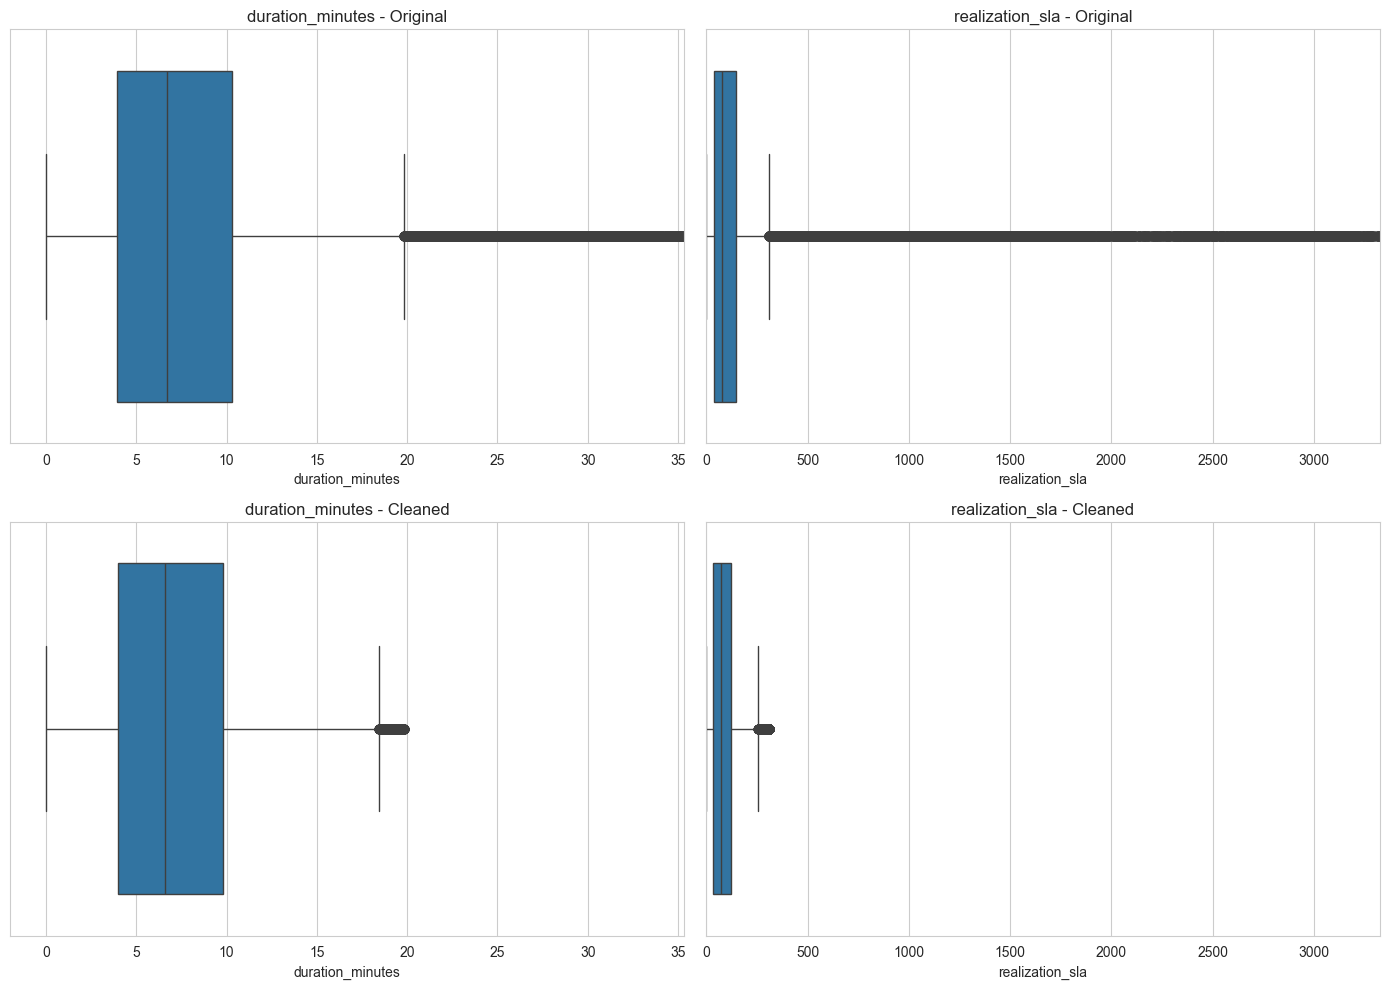

In [106]:
# --- Função de remoção de outliers com limite inferior >= 0 ---
def remove_outliers_iqr_positive(dataframe, column_name):
    Q1 = dataframe[column_name].quantile(0.25)
    Q3 = dataframe[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(0, Q1 - 1.5 * IQR)  # limite inferior nunca negativo
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = dataframe[(dataframe[column_name] >= lower_bound) & (dataframe[column_name] <= upper_bound)]
    
    print(f"Original shape for {column_name}: {dataframe.shape}")
    print(f"Shape after removing outliers for {column_name}: {df_filtered.shape}\n")
    
    return df_filtered

# --- Remover valores negativos impossíveis antes do Tukey ---
df = df[df['realization_sla'] >= 0]
df = df[df['duration_minutes'] >= 0]  # só por segurança

# --- Aplicar Tukey/IQR ---
df_clean = remove_outliers_iqr_positive(df, 'duration_minutes')
df_clean = remove_outliers_iqr_positive(df_clean, 'realization_sla')

columns_to_plot = ['duration_minutes', 'realization_sla']
zoom_limits_upper = {col: df[col].quantile(0.99) for col in columns_to_plot}  # limite superior 99%
margin = 2  # espaço antes de 0

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(columns_to_plot):
    # Boxplot original
    sns.boxplot(x=df[col], ax=axes[0, i])
    axes[0, i].set_title(f'{col} - Original')
    axes[0, i].set_xlim(-margin, zoom_limits_upper[col])  # pequeno espaço antes de 0
    
    # Boxplot limpo
    sns.boxplot(x=df_clean[col], ax=axes[1, i])
    axes[1, i].set_title(f'{col} - Cleaned')
    axes[1, i].set_xlim(-margin, zoom_limits_upper[col])  # mesma escala

plt.tight_layout()
plt.show()



# Explorar Associações

C:\Users\Mariana Saavedra\AppData\Local\Temp\ipykernel_16028\3522644139.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


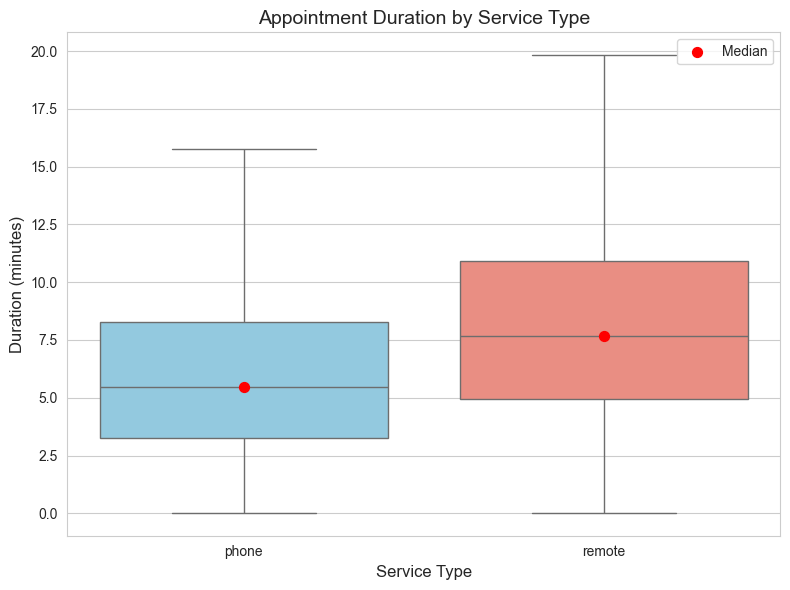

C:\Users\Mariana Saavedra\AppData\Local\Temp\ipykernel_16028\3522644139.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inperson['in_person_appointment_evaluation'] = pd.Categorical(


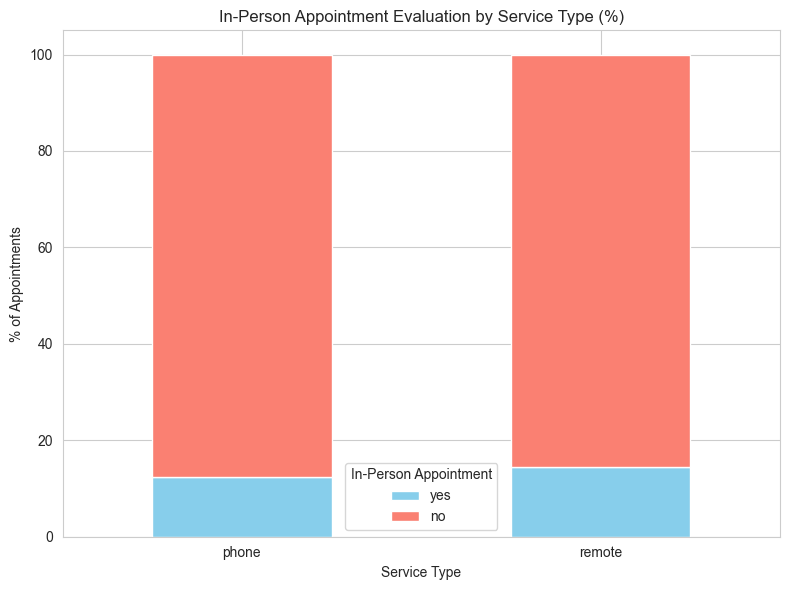

Chi-squared test for In-Person Appointment: p-value = 0.0000
Cramer's V: 0.031


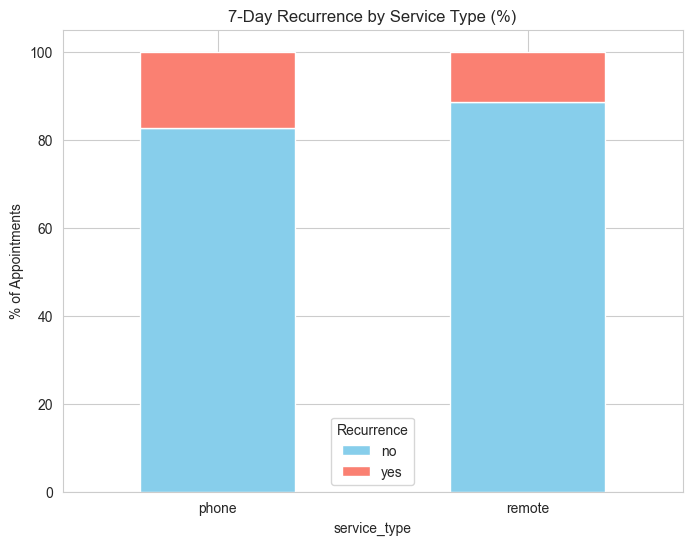

Chi-squared test for 7-Day Recurrence: p-value = 0.0000
Cramer's V: 0.083


In [107]:
from scipy.stats import mannwhitneyu, chi2_contingency

# Set plot style
sns.set_style("whitegrid")

# --- 1. Service Type vs. Duration ---
plt.figure(figsize=(8,6))

# Boxplot with custom colors and no outliers
sns.boxplot(
    x='service_type', 
    y='duration_minutes', 
    data=df_clean, 
    palette=['skyblue', 'salmon'],  # custom colors
    showfliers=False
)

# Overlay median with a red point
medians = df_clean.groupby('service_type')['duration_minutes'].median().values
for i, median in enumerate(medians):
    plt.scatter(i, median, color='red', s=50, zorder=10, label='Median' if i==0 else "")

plt.title('Appointment Duration by Service Type', fontsize=14)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.xlabel('Service Type', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 2. Service Type vs in_person_appointment_evaluation
# -------------------------------

# --- Filter out NaNs for in_person_appointment_evaluation ---
df_inperson = df_clean[df_clean['in_person_appointment_evaluation'].notna()]

# --- Ensure consistent category order (use actual values 'yes' and 'no') ---
df_inperson['in_person_appointment_evaluation'] = pd.Categorical(
    df_inperson['in_person_appointment_evaluation'],
    categories=['yes', 'no'],  # lowercase to match your data
    ordered=True
)

# --- Crosstab ---
rec_ct = pd.crosstab(
    df_inperson['service_type'],
    df_inperson['in_person_appointment_evaluation']
)

# --- Convert counts to percentages and ensure numeric ---
rec_pct = rec_ct.div(rec_ct.sum(axis=1), axis=0) * 100
rec_pct = rec_pct.apply(pd.to_numeric, errors='coerce')  # force numeric

# --- Plot stacked bar chart ---
rec_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(8,6),
    color=['skyblue', 'salmon']
)
plt.title('In-Person Appointment Evaluation by Service Type (%)')
plt.ylabel('% of Appointments')
plt.xlabel('Service Type')
plt.xticks(rotation=0)
plt.legend(title='In-Person Appointment')
plt.tight_layout()
plt.show()

# --- Chi-squared test ---
chi2, p_value_inperson, _, _ = chi2_contingency(rec_ct)
n = rec_ct.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(rec_ct.shape)-1)))

print(f"Chi-squared test for In-Person Appointment: p-value = {p_value_inperson:.4f}")
print(f"Cramer's V: {cramers_v:.3f}")




# -------------------------------
# 3. Service Type vs 7-Day Recurrence
# -------------------------------
recurrence_ct = pd.crosstab(df_clean['service_type'], df_clean['recurrence_7days'])

# Normalize for percentage
recurrence_pct = recurrence_ct.div(recurrence_ct.sum(axis=1), axis=0) * 100

recurrence_pct.plot(kind='bar', stacked=True, figsize=(8,6), color=['skyblue', 'salmon'])
plt.title('7-Day Recurrence by Service Type (%)')
plt.ylabel('% of Appointments')
plt.xticks(rotation=0)
plt.legend(title='Recurrence')
plt.show()

# Chi-squared test
chi2, p_value_recurrence, _, _ = chi2_contingency(recurrence_ct)
print(f"Chi-squared test for 7-Day Recurrence: p-value = {p_value_recurrence:.4f}")

# Calculate effect size (Cramer's V)
n = recurrence_ct.sum().sum()
phi2 = chi2/n
r, k = recurrence_ct.shape
cramers_v = np.sqrt(phi2 / (min(r-1, k-1)))
print(f"Cramer's V: {cramers_v:.3f}")

In [ ]:
from scipy.stats import mannwhitneyu, chi2_contingency
import pandas as pd
import numpy as np

summary_data = []

# 1. Duration vs Service Type
service_types = df_clean['service_type'].unique()
g1 = df_clean[df_clean['service_type']==service_types[0]]['duration_minutes']
g2 = df_clean[df_clean['service_type']==service_types[1]]['duration_minutes']
stat, p = mannwhitneyu(g1, g2)
effect_size_duration = np.median(g1) - np.median(g2)
summary_data.append(['duration_minutes', 'Mann-Whitney U', p, effect_size_duration, 'Difference in median'])

# 2. In-Person Appointment vs Service Type
chi2, p, _, _ = chi2_contingency(rec_ct)
n = rec_ct.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(rec_ct.shape)-1)))
summary_data.append(['in_person_appointment_evaluation', 'Chi2', p, cramers_v, "Effect size Cramer's V"])

# 3. 7-Day Recurrence vs Service Type
df_clean_rec = df_clean[df_clean['recurrence_7days'].notna()]
rec_ct2 = pd.crosstab(df_clean_rec['service_type'], df_clean_rec['recurrence_7days'])
chi2, p, _, _ = chi2_contingency(rec_ct2)
n = rec_ct2.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(rec_ct2.shape)-1)))
summary_data.append(['recurrence_7days', 'Chi2', p, cramers_v, "Effect size Cramer's V"])

# Convert to DataFrame
summary_df = pd.DataFrame(summary_data, columns=['Variable', 'Test', 'p-value', 'Effect Size', 'Interpretation'])
summary_df


,Variable,Test,p-value,Effect Size,Interpretation
0,duration_minutes,Mann-Whitney U,0.000000e+00,-2.200000,Difference in median
1,in_person_appointment_evaluation,Chi2,8.541749e-17,0.030868,Effect size Cramer's V
2,recurrence_7days,Chi2,3.220233e-267,0.082841,Effect size Cramer's V


# Guardar dados limpos

In [109]:
df_clean

,appointment_id,tenant,created_at,updated_at,start_time,end_time,started_at,finished_at,realization_sla,duration_minutes,...,icd_code2,icd_code3,patient_age_at_appointment,patient_sex,in_person_appointment_evaluation,recurrence_24hours,recurrence_48hours,recurrence_72hours,recurrence_7days,process_date
0,295538,knok,2022-12-16 19:14:15.023083+00:00,2022-12-16 19:39:09.718106+00:00,2022-12-16 19:33:00+00:00,2022-12-16 19:41:30+00:00,2022-12-16 19:37:00.386294+00:00,2022-12-16 19:39:09.718006+00:00,18.73,2.15,...,,,42.0,F,yes,no,no,no,no,2022-12-16
1,295351,knok,2022-12-16 16:01:59.908535+00:00,2022-12-16 16:25:47.131449+00:00,2022-12-16 16:12:00+00:00,2022-12-16 16:20:30+00:00,2022-12-16 16:19:36.029042+00:00,2022-12-16 16:25:47.131367+00:00,10.00,6.18,...,,,72.0,M,no,no,no,no,no,2022-12-16
2,294943,knok,2022-12-16 10:10:53.914403+00:00,2022-12-16 10:32:59.524845+00:00,2022-12-16 10:25:00+00:00,2022-12-16 10:33:30+00:00,2022-12-16 10:27:38.144952+00:00,2022-12-16 10:32:59.524751+00:00,14.08,5.35,...,,,67.0,F,no,no,no,no,no,2022-12-16
3,294938,knok,2022-12-16 10:09:08.076024+00:00,2022-12-16 10:37:13.030372+00:00,2022-12-16 10:25:00+00:00,2022-12-16 10:33:30+00:00,2022-12-16 10:27:29.164846+00:00,2022-12-16 10:37:13.030278+00:00,15.85,9.72,...,,,72.0,F,,no,no,no,no,2022-12-16
4,294963,knok,2022-12-16 10:19:30.418240+00:00,2022-12-16 10:30:43.604808+00:00,2022-12-16 10:25:00+00:00,2022-12-16 10:33:30+00:00,2022-12-16 10:27:54.577001+00:00,2022-12-16 10:30:43.604693+00:00,5.48,2.82,...,,,68.0,M,no,no,no,no,no,2022-12-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219795,295419,knok,2022-12-16 17:05:38.817851+00:00,2022-12-16 17:43:43.025460+00:00,2022-12-16 17:24:00+00:00,2022-12-16 17:32:30+00:00,2022-12-16 17:22:30.201943+00:00,2022-12-16 17:27:21.687370+00:00,18.35,4.85,...,,,66.0,F,no,no,no,no,no,2022-12-16
219796,295421,knok,2022-12-16 17:07:07.970873+00:00,2022-12-16 17:55:25.560543+00:00,2022-12-16 17:24:00+00:00,2022-12-16 17:32:30+00:00,2022-12-16 17:50:39.172370+00:00,2022-12-16 17:55:25.559464+00:00,16.85,4.77,...,,,6.0,M,,no,no,no,no,2022-12-16
219797,294945,knok,2022-12-16 10:11:32.911945+00:00,2022-12-16 10:48:55.028508+00:00,2022-12-16 10:42:00+00:00,2022-12-16 10:50:30+00:00,2022-12-16 10:43:39.783357+00:00,2022-12-16 10:48:55.028417+00:00,30.45,5.25,...,,,47.0,F,no,no,no,no,no,2022-12-16
219798,294973,knok,2022-12-16 10:25:22.576545+00:00,2022-12-16 10:50:45.160729+00:00,2022-12-16 10:42:00+00:00,2022-12-16 10:50:30+00:00,2022-12-16 10:45:39.837810+00:00,2022-12-16 10:50:45.160628+00:00,16.62,5.08,...,,,55.0,F,no,no,no,no,no,2022-12-16


In [110]:
df_clean.to_csv("../data/df_clean.csv", index=False)
df_clean.to_pickle("../data/df_clean.pkl")